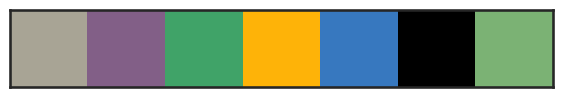

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
from pprint import pprint
import re as re
import os

from statsmodels.regression.mixed_linear_model import MixedLMResults

import scipy as sp
#from scipy.stats import nanmean
#from scipy.stats import nanstd
import copy
import scipy.stats as stats
import string

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pprint import pprint
import seaborn as sns
sns.set(style="white", context="talk")
custom_palette = [ "greyish", "dusty purple", "greenish", "amber", "windows blue", "black","faded green"]  
                     #"green blue", "dull green", "faded green",  
sns.set_palette(sns.xkcd_palette(custom_palette))
current_palette = sns.color_palette()
%matplotlib inline
sns.palplot(current_palette)

import warnings
warnings.filterwarnings('ignore')


In [14]:
colors ={
         'dynamic_network': '#81B200',
         'static_network':'#9B59B6',
         'solo_self_feedback': '#95A5A6',
        }

linestyles ={
         'dynamic_network': '-',
         'static_network':'--',
         'solo_self_feedback': '-',
        }

markers ={
         'dynamic_network': 'o',
         'static_network':'*',
         'solo_self_feedback': 'H',
        }

tick_size = 25
label_size = 35

In [16]:

conditions = ["solo_self_feedback", "static_network", "dynamic_network"]




def agregate_result(experiment_number: str):
    folders = [f"solo_self_feedback_2", f"static_network_{experiment_number}", f"dynamic_network_{experiment_number}"]
    games = []
    for folder in folders:
        subfolder = [f.name for f in os.scandir(f"results/{folder}") if f.is_dir()]
        for game_id in subfolder:
            data = pd.read_csv("results/{}/{}/data.csv".format(folder, game_id))
            condition = "_".join(folder.split("_")[:-1])
            data["game_id"] = game_id
            data["condition"] = condition
            games.append(data)
    return pd.concat(games)

experiments_types = [agregate_result("2"), agregate_result("3")] # [basic prompting, confidence prompting]

In [17]:
for experiments in experiments_types:
    experiments["revised_guess"] = np.where(experiments["condition"] == "solo_self_feedback", experiments["independent_guess"], experiments["revised_guess"])
    experiments["half"] = (experiments["round_index"] > 4).astype(int) + 1

    experiments["quarter"] = 1
    experiments.loc[(experiments['round_index'] >= 3) & (experiments['round_index'] < 5), "quarter"] = 2
    experiments.loc[(experiments['round_index'] >= 5) & (experiments['round_index'] < 8), "quarter"] = 3
    experiments.loc[experiments['round_index'] >= 8, "quarter"] = 4


In [48]:

formated_experiments_types = []
for experiments in experiments_types:
    """
    Set revised_wisdom_error for each round_index of each game_id
    - The absolute difference between the correct answer and the mean of the revised guesses
    """

    experiments["independent_error"] = abs(experiments["correct_answer"] - experiments["independent_guess"]) / 100
    experiments["revised_error"] = abs(experiments["correct_answer"] - experiments["revised_guess"]) / 100


    experiments['revised_guess_mean_round'] = experiments.groupby(['game_id', 'round_index'])['revised_guess'].transform('mean')
    experiments['revised_mean_error_round'] = experiments.groupby(['game_id', 'round_index'])['revised_error'].transform('mean')

    experiments['independent_guess_mean_round'] = experiments.groupby(['game_id', 'round_index'])['independent_guess'].transform('mean')
    experiments['independent_mean_error_round'] = experiments.groupby(['game_id', 'round_index'])['independent_error'].transform('mean')

    solo_experiment = experiments[experiments.condition == "solo_self_feedback"]
    solo_experiment["task_instance_avg_error"] = solo_experiment.groupby(['round_index', 'difficulty'])['independent_error'].transform('mean')

    # make df called image_error of round_index, difficulty, task_instance_avg_error
    image_error = solo_experiment.groupby(['round_index', 'difficulty'])['task_instance_avg_error'].mean().reset_index()


    """ set task_instance_avg_error
    - It represents the average error of the independent guesses for 
        - all game_id with condition "solo_self_feedback"
        - same round_index
        - Same difficulty level (easy, medium, hard)
    """

    formated_experiments = pd.merge(experiments, image_error, how='left')
    formated_experiments['revised_mean_error_relative2solo'] = formated_experiments.revised_mean_error_round - formated_experiments.task_instance_avg_error
    formated_experiments['revised_error_relative2solo'] = formated_experiments.revised_error - formated_experiments.task_instance_avg_error
    # sort by game_id round_index player_id
    formated_experiments = formated_experiments.sort_values(by=['game_id', 'round_index']).drop_duplicates()

    formated_experiments["best_revised_choice"] = formated_experiments.groupby(['game_id', 'round_index'])['revised_error'].transform(lambda x: x == x.min())

    formated_experiments_types.append(formated_experiments)


In [49]:
# Group-level DataFrame: one row per game_id and round_index

formated_experiments = formated_experiments_types[0].copy() # normal prompting
group_level_df = (
    formated_experiments[[
        'game_id', 'round_index', 'difficulty', 'condition',
        'revised_mean_error_relative2solo', 'quarter', 'half'
    ]]
    .drop_duplicates(subset=['game_id', 'round_index', 'revised_mean_error_relative2solo'])
    .copy()
)


# Save or display
group_level_df

,game_id,round_index,difficulty,condition,revised_mean_error_relative2solo,quarter,half
180,152984,0,easy,static_network,0.091667,1,1
190,152984,0,medium,static_network,0.073333,1,1
200,152984,0,hard,static_network,-0.393333,1,1
181,152984,1,easy,static_network,0.496667,1,1
191,152984,1,medium,static_network,-0.103333,1,1
...,...,...,...,...,...,...,...
498,974473,8,easy,dynamic_network,0.136667,4,2
508,974473,8,medium,dynamic_network,0.095000,4,2
489,974473,9,hard,dynamic_network,0.116667,4,2
499,974473,9,easy,dynamic_network,0.193333,4,2


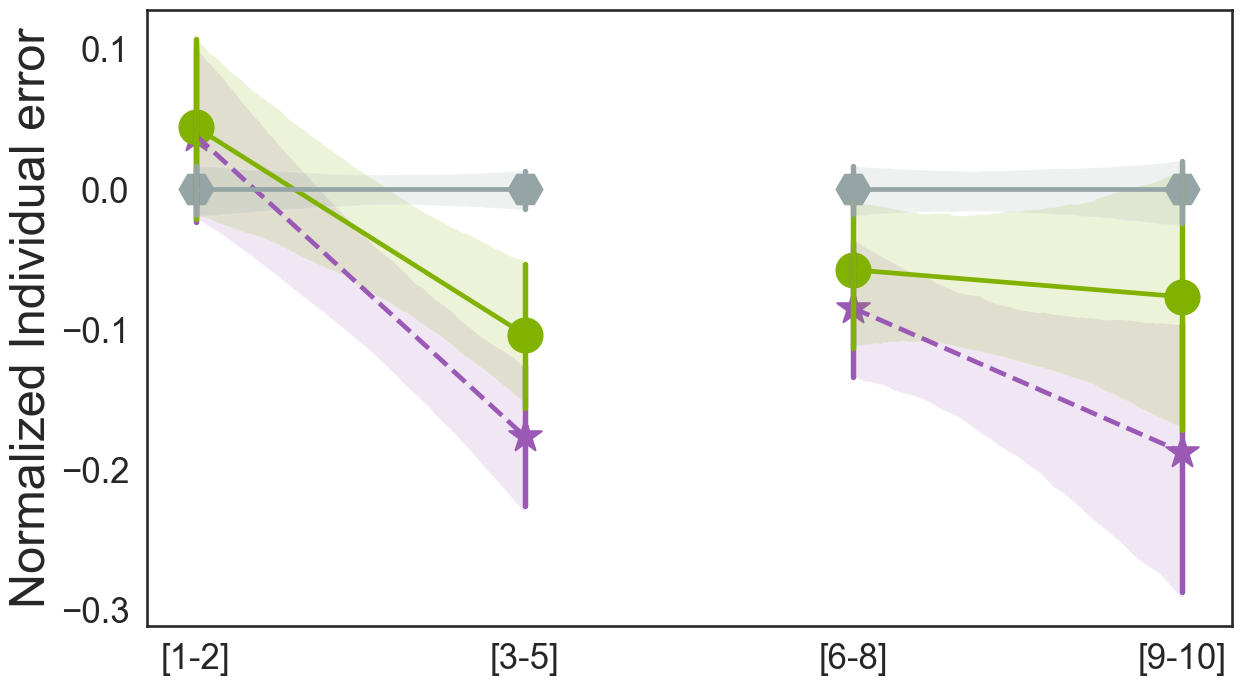

In [50]:
x_formatter = ticker.FixedFormatter([
    "[1-2]", "[3-5]", "[6-8]", "[9-10]"])
x_locator = ticker.FixedLocator([1, 2, 3, 4])


fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
for half in range(1,3):
    for condition in formated_experiments.condition.unique():
        sns.regplot(x="quarter",
                    y="revised_error_relative2solo",
                    data=formated_experiments[(formated_experiments.half==half) & (formated_experiments.condition==condition)],
                    x_estimator=np.mean, ax=ax,
                    truncate=True,
                    marker=markers[condition],
                    color=colors[condition],
                    line_kws = {'linestyle':linestyles[condition]},
                    scatter_kws ={'s':600},
                    
                    fit_reg=True,
                    ci=95,
                    label=condition,
                    )
            
ax.set_xlabel("",fontsize=label_size)
ax.set_ylabel('Normalized Individual error',fontsize=label_size)

ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)

ax.tick_params(labelsize=tick_size)

#save the plot
plt.savefig("figures/individual3.png", bbox_inches='tight')


static_network
*
dynamic_network
o
solo_self_feedback
H
static_network
*
dynamic_network
o
solo_self_feedback
H


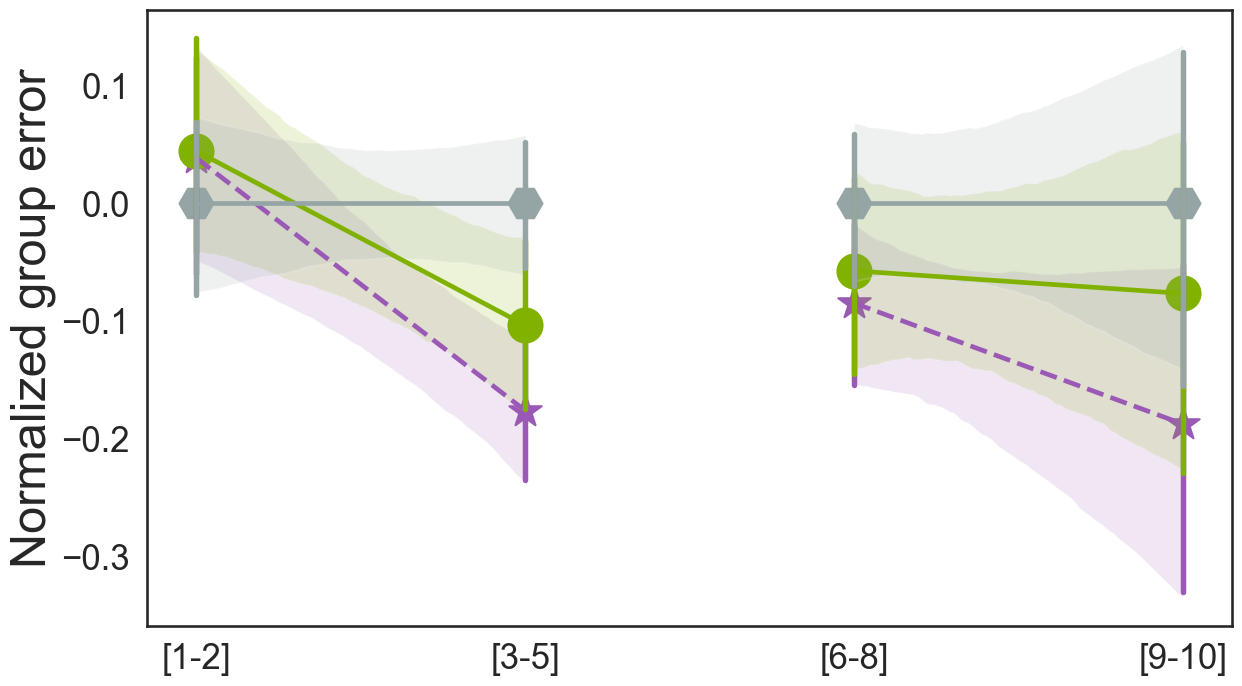

In [51]:
x_formatter = ticker.FixedFormatter([
    "[1-2]", "[3-5]", "[6-8]", "[9-10]"])
x_locator = ticker.FixedLocator([1, 2, 3, 4])

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
for half in range(1,3):
    for condition in group_level_df.condition.unique():
        print(condition)
        print(markers[condition])
        sns.regplot(x="quarter",
                    y="revised_mean_error_relative2solo",
                    data=group_level_df[(formated_experiments.half==half) & (formated_experiments.condition==condition)],
                    x_estimator=np.mean, ax=ax,
                    truncate=True,
                    marker=markers[condition],
                    color=colors[condition],
                    line_kws = {'linestyle':linestyles[condition]},
                    scatter_kws ={'s':600},
                    
                    fit_reg=True,
                    ci=95,
                    label=condition,
                    )
            
ax.set_xlabel("",fontsize=label_size)
ax.set_ylabel('Normalized group error',fontsize=label_size)

ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)

ax.tick_params(labelsize=tick_size)


plt.savefig("figures/group_error3.png", bbox_inches='tight')

In [52]:
# open csv article_data/all_studies_round_data.csv
all_studies_round_data = pd.read_csv("article_data/all_studies_round_data.csv")

""" only keep lines with conditions :   'static', 'dynamic' 'solo_feedback' """
all_studies_round_data = all_studies_round_data[all_studies_round_data.condition.isin(["static", "dynamic", "solo_feedback"])]
human_error_per_round = all_studies_round_data.groupby(['condition', 'round_index'])['revised_error'].mean().reset_index()
human_error_per_round = human_error_per_round.sort_values(['condition', 'round_index'])
human_error_per_round.condition = human_error_per_round.condition.str.replace("solo_feedback", "solo_self_feedback")
human_error_per_round.condition = human_error_per_round.condition.str.replace("static", "static_network")
human_error_per_round.condition = human_error_per_round.condition.str.replace("dynamic", "dynamic_network")


ai_error_per_round = [ formated_experiments_type.groupby(['condition', 'round_index'])['revised_error'].mean().reset_index() for formated_experiments_type in formated_experiments_types ]



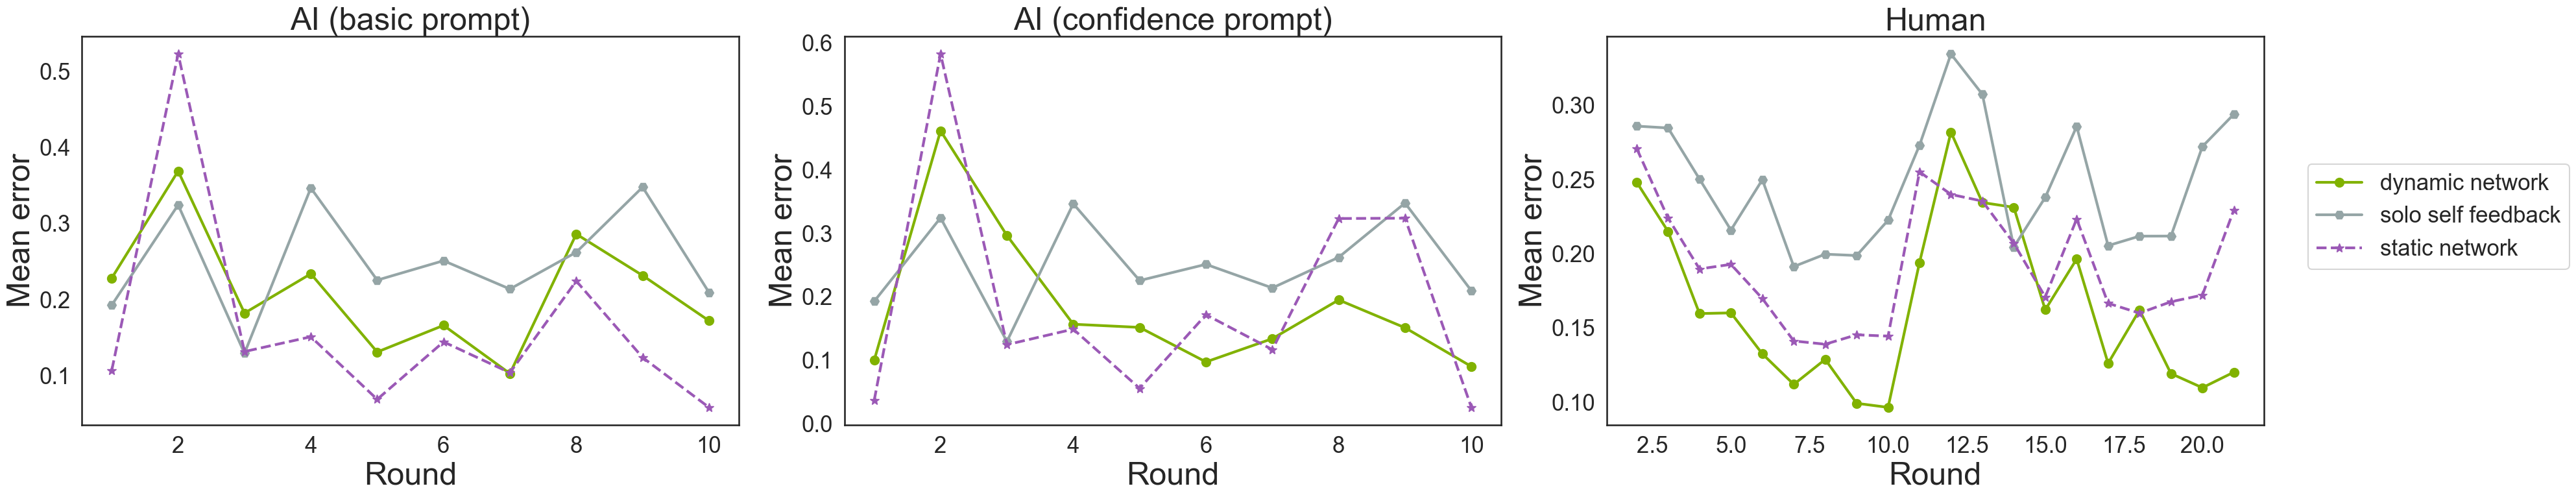

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(40, 8))  # Create a figure with 3 subplots side by side

for ax, errors, title in zip(axes, [ai_error_per_round[0], ai_error_per_round[1], human_error_per_round], ["AI (basic prompt)", "AI (confidence prompt)", "Human"]):
    for condition in ai_error_per_round[0]['condition'].unique():
        ax.plot(
            errors[errors.condition == condition].round_index + 1,
            errors[errors.condition == condition].revised_error,
            label=" ".join(condition.split("_")),
            markersize=10,
            linewidth=3,
            marker=markers[condition],
            color=colors[condition],
            linestyle=linestyles[condition],
        )
        
    ax.set_xlabel("Round", fontsize=label_size)
    ax.set_ylabel('Mean error', fontsize=label_size)
    ax.set_title(title, fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)


axes[-1].legend(fontsize=tick_size, bbox_to_anchor=(1.05, 0.7))

plt.tight_layout()  # Adjust layout to prevent overlap

plt.savefig("figures/ai_human_error.png", bbox_inches='tight')


In [54]:
formated_experiments.columns

Index(['player_id', 'condition', 'round_index', 'correct_answer',
       'independent_guess', 'revised_guess', 'neighbors_choice', 'score',
       'difficulty', 'alter_1', 'alter_2', 'alter_3', 'in_degree',
       'independent_error', 'revised_error', 'cumulative_score', 'increment',
       'round_after_shock', 'game_id', 'half', 'quarter',
       'revised_guess_mean_round', 'revised_mean_error_round',
       'independent_guess_mean_round', 'independent_mean_error_round',
       'task_instance_avg_error', 'revised_mean_error_relative2solo',
       'revised_error_relative2solo', 'best_revised_choice'],
      dtype='object')

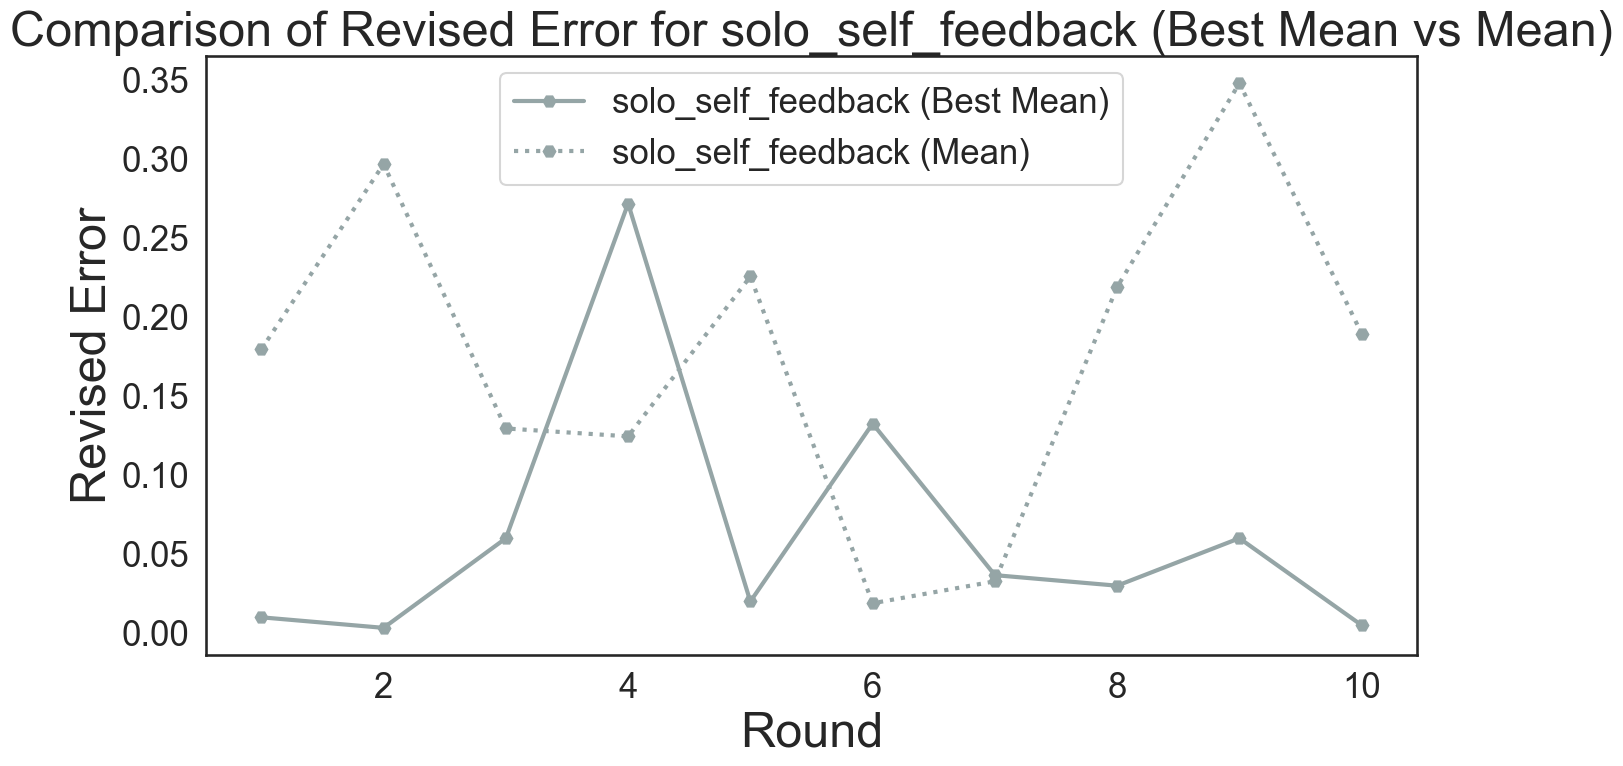

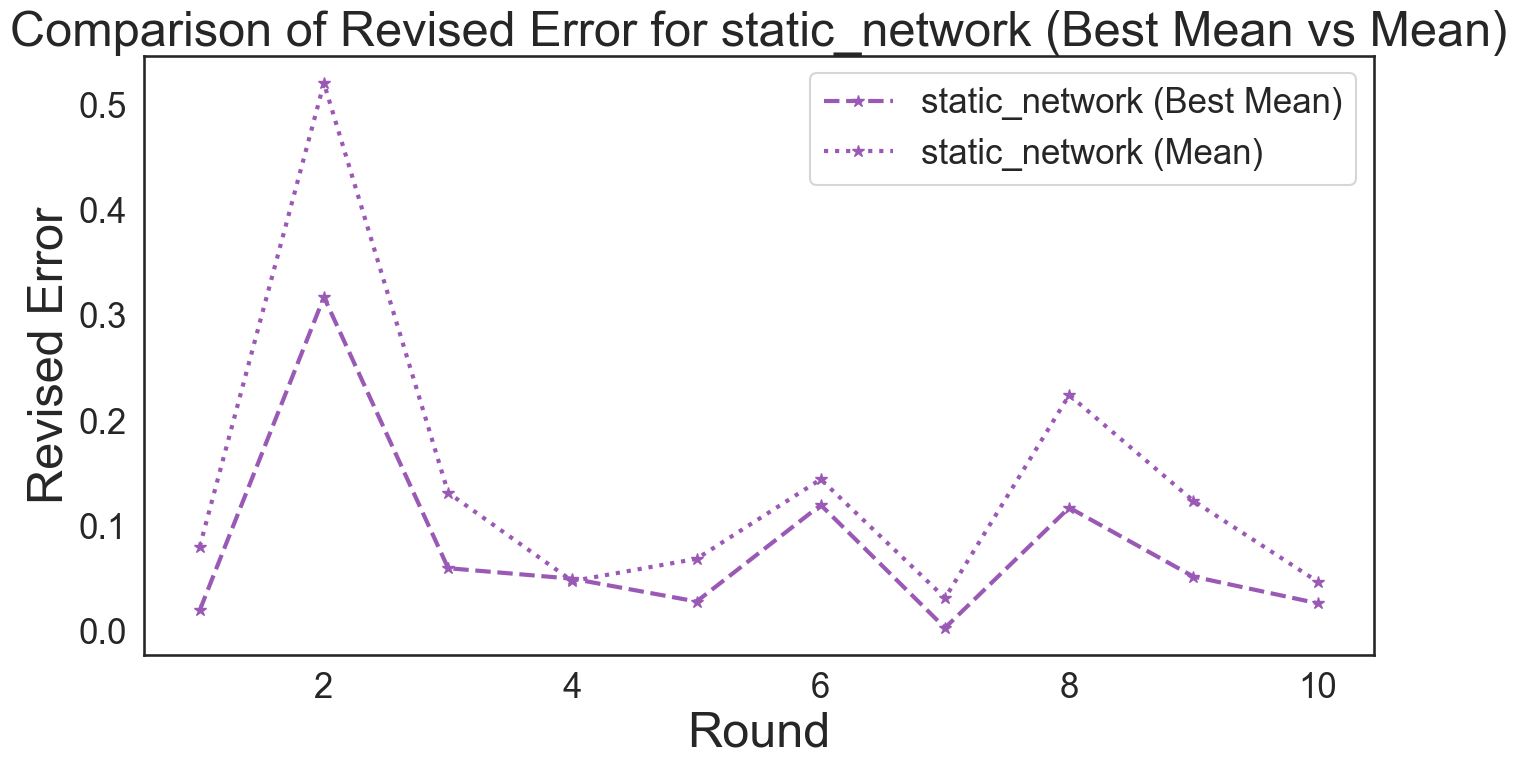

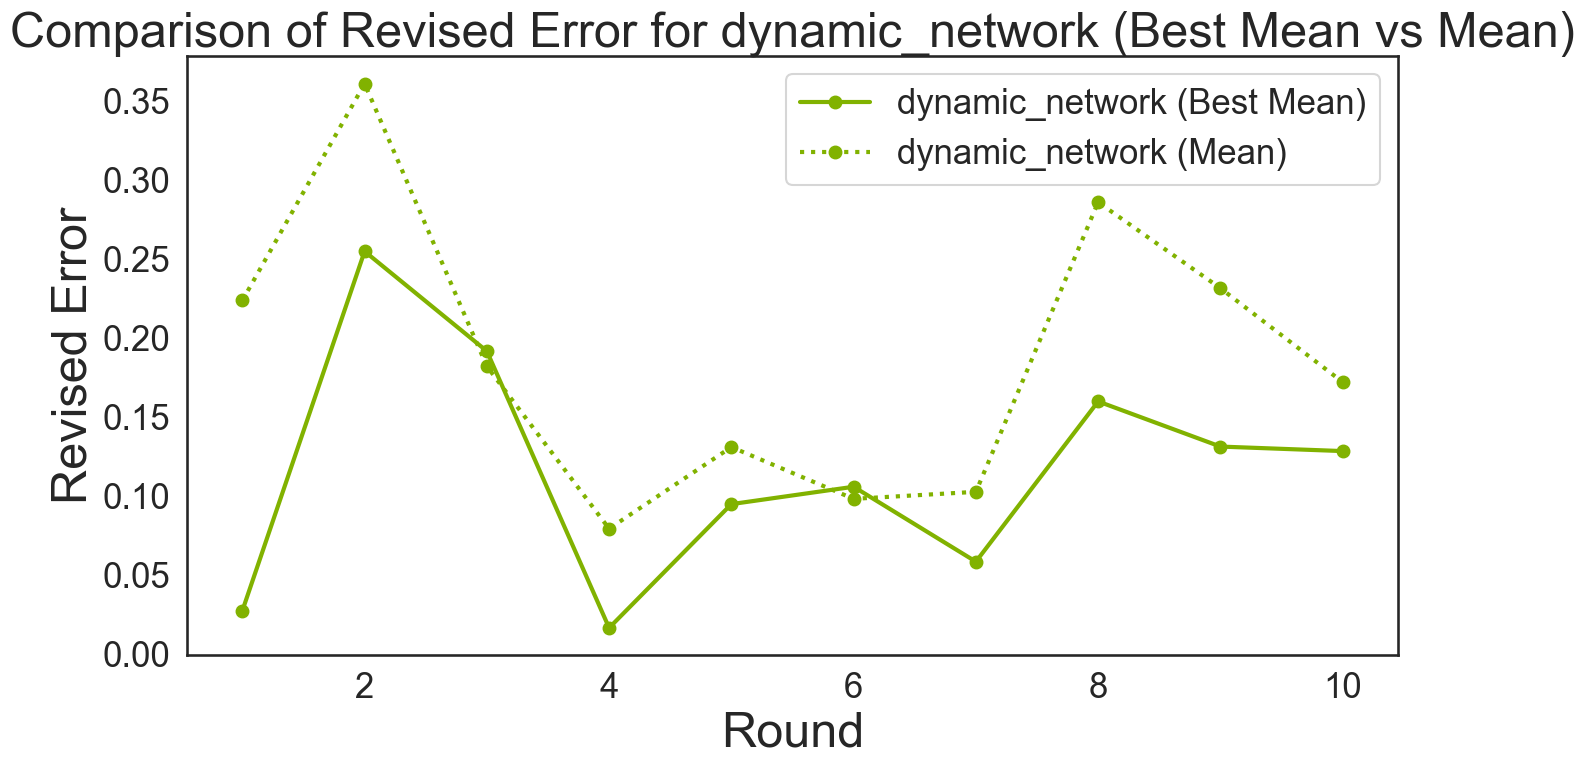

In [55]:

# mean of the best revised_error (ie the row with best_revised_choice==True) for each round_index, condition
best_mean_revised_guess = formated_experiments[formated_experiments.best_revised_choice].groupby(['round_index', 'condition', 'correct_answer'])['revised_guess'].mean().reset_index()
best_mean = best_mean_revised_guess.sort_values(['condition', 'round_index'])

mean = formated_experiments.groupby(['round_index', 'condition', 'correct_answer'])['revised_guess'].mean().reset_index().sort_values(['condition', 'round_index'])


# compute the diff between the 'correct_answer' and the revised_guess

best_mean["revised_error"] = abs(best_mean["correct_answer"] - best_mean["revised_guess"]) / 100
mean["revised_error"] = abs(mean["correct_answer"] - mean["revised_guess"]) / 100

for condition in conditions:
    # Filter data for the current condition
    best_mean_condition = best_mean[best_mean['condition'] == condition]
    mean_condition = mean[mean['condition'] == condition]
    
    # Create a new figure for the current condition
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot best_mean revised error
    ax.plot(
        best_mean_condition['round_index'] + 1,
        best_mean_condition['revised_error'],
        label=f"{condition} (Best Mean)",
        marker=markers[condition],
        linestyle=linestyles[condition],
        color=colors[condition],
        linewidth=3,
    )
    
    # Plot mean revised error
    ax.plot(
        mean_condition['round_index'] + 1,
        mean_condition['revised_error'],
        label=f"{condition} (Mean)",
        marker=markers[condition],
        linestyle=':',
        color=colors[condition],
        linewidth=3,
    )
    
    # Set labels, title, and legend
    ax.set_xlabel("Round", fontsize=label_size)
    ax.set_ylabel("Revised Error", fontsize=label_size)
    ax.set_title(f"Comparison of Revised Error for {condition} (Best Mean vs Mean)", fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    ax.legend(fontsize=tick_size)
    
    plt.tight_layout()
    plt.show()


In [56]:
# check for the condition dynamic_network for each game_id the percentage of players which has the best player 'player_id' variable in their 'neighbors_choice' array
# best_revised_choice : bool == true --> best player
from itertools import count

for formated_experiments_type in formated_experiments_types:
    dynamic_network = formated_experiments_type.copy()[formated_experiments_type.condition == "dynamic_network"]
    dynamic_network = dynamic_network[["game_id", "player_id", "round_index", "neighbors_choice", "best_revised_choice"]]

    # turn neighbors_choice variable into a list of int
    dynamic_network["neighbors_choice"] = dynamic_network["neighbors_choice"].apply(lambda x: eval(x) if isinstance(x, str) else [])



    count_best_choice = 0
    for game_id in dynamic_network.game_id.unique():
        game = dynamic_network[dynamic_network.game_id == game_id]
        for round_index in game.round_index.unique():
            best_player_id = game[(game.best_revised_choice == True) & (game.round_index == round_index)].player_id.values[0]
            neighbors_choices = game[(game.round_index == round_index)].neighbors_choice.values
            count_best_choice += sum([1 for neighbors_choice in neighbors_choices if best_player_id in neighbors_choice])



    count_best_choice = count_best_choice / (len(dynamic_network.game_id.unique()) * (len(dynamic_network.round_index.unique())-1) * (len(dynamic_network.player_id.unique())-1))

    print(count_best_choice)

0.6222222222222222
0.6888888888888889


In [ ]:
# count number of game_id for each condition for both "all_studies_round_data" and "formated_experiment"
a = all_studies_round_data[["game_id", "condition"]]
a = a.drop_duplicates()
a = a.groupby(['condition']).count().reset_index()

a



,condition,game_id
0,dynamic,20
1,solo_feedback,239
2,static,20
